In [20]:
import os

import pandas as pd
from sklearn.preprocessing import LabelEncoder

dataset_name = "folktables"
dataset_path = os.path.join("..", "data", dataset_name)

ft_path = os.path.join("..", "data", "folktables")
if not os.path.exists(os.path.join(ft_path, "features.csv")) or not os.path.exists(os.path.join(ft_path, "labels.csv")):
    raise RuntimeError("Folktables original data not found!")

features = pd.read_csv(os.path.join(ft_path, "features.csv"))
labels = pd.read_csv(os.path.join(ft_path, "labels.csv"))
print("Loaded folk tables dataset (rows: %d)" % len(features))

Loaded folk tables dataset (rows: 5916565)


In [21]:
X = features
y = labels

In [22]:
# encode X.AGEP into a categorical variable with bins < 25, 25-50, > 50
age_bins = [0, 25, 50, 100]
age_labels = [0, 1, 2]
X["AGEP"] = pd.cut(X["AGEP"], bins=age_bins, labels=age_labels, include_lowest=True)

In [23]:
attributes = ["MAR", "SEX", "NATIVITY", "MIG"]

# encode categorical variables
le = LabelEncoder()
for attr in attributes:
    X[attr] = le.fit_transform(X[attr])

In [24]:
X.MAR.unique(), X.NATIVITY.unique(), X.MIG.unique(), X.SEX.unique(), X.AGEP.unique()

(array([0, 4, 2, 3, 1]),
 array([0, 1]),
 array([0, 2, 1]),
 array([1, 0]),
 [2, 1, 0]
 Categories (3, int64): [0 < 1 < 2])

In [25]:
y['PUBCOV'] = y['PUBCOV'].apply(lambda x: 0 if not x else 1)
y = y.rename(columns={"PUBCOV": "Y"})

In [27]:
X = X.reset_index(drop=True)
X.to_csv(os.path.join("..", "data", dataset_name, "ma_features.csv"), index=False)
y.to_csv(os.path.join("..", "data", dataset_name, "ma_labels.csv"), index=False)

## ------------- Compute strata sizes -------------

In [28]:
def get_sum_value(nested_dict):
    sum_value = 0
    for _, v in nested_dict.items():
        if isinstance(v, dict):
            v = get_sum_value(v)
        sum_value += v
    return sum_value

def get_max_value(nested_dict):
    max_value = 0
    for _, v in nested_dict.items():
        if isinstance(v, dict):
            v = get_max_value(v)
        if v > max_value:
            max_value = v
    return max_value

In [29]:
X_path = os.path.join("..", "data", dataset_name, "ma_features.csv")
y_path = os.path.join("..", "data", dataset_name, "ma_labels.csv")

# read in the data
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

In [30]:
protected_attributes = ["SEX", "MAR", "AGEP", "NATIVITY", "MIG"]
possible_values = [len(X[attr].unique()) for attr in protected_attributes]
value_sets = [set(range(possible_values[i])) for i in range(len(possible_values))]

In [31]:
possible_values

[2, 5, 3, 2, 3]

In [32]:
from itertools import combinations, product
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [33]:
features = X
labels = y
n = len(protected_attributes)

all_probs = dict()
all_ys = dict()
all_nks = dict()

for base_agent in range(n): # Base agent
    print(f'Working on base agent {base_agent}')
    base_attr = protected_attributes[base_agent]
    possible_collaborators = [i for i in range(n) if i != base_agent]
    all_probs[base_agent] = dict()
    all_ys[base_agent] = dict()
    all_nks[base_agent] = dict()

    for k in range(0, n): # Number of collaborators, 1 to n-1

        print(f'Working on k={k}')
        all_probs[base_agent][k] = dict()
        all_ys[base_agent][k] = dict()
        all_nks[base_agent][k] = dict()

        agent_combinations_list = list(combinations(possible_collaborators, k))

        for agent_combination in agent_combinations_list:
            agent_comb_str = ''.join([str(elem) for elem in agent_combination])

            all_probs[base_agent][k][agent_comb_str] = dict()
            all_ys[base_agent][k][agent_comb_str] = dict()
            all_nks[base_agent][k][agent_comb_str] = dict()

            current_set = [value_sets[i] for i in agent_combination]
            value_strings = list(product(*current_set))
            value_strings = ["".join([str(elem) for elem in value_string]) for value_string in value_strings]

            attrs = [protected_attributes[i] for i in agent_combination]
            print(f'Working on {attrs}')
            for value_string in value_strings:

                all_probs[base_agent][k][agent_comb_str][value_string] = dict()
                all_ys[base_agent][k][agent_comb_str][value_string] = dict()
                all_nks[base_agent][k][agent_comb_str][value_string] = dict()

                pairs = [(attrs[i], int(value_string[i])) for i in range(k)]

                base_agent_value_set = value_sets[base_agent]
                
                for base_agent_value in base_agent_value_set:
                    X_temp = features.copy()
                    X_temp = X_temp[X_temp[base_attr] == base_agent_value]
                    X_temp_i = X_temp.copy()
                    for attr, val in pairs:
                        X_temp = X_temp[X_temp[attr] == val]
                    y_tmp = labels.loc[X_temp.index]
                    assert len(X_temp) == len(y_tmp), f'Length mismatch ==> X: {len(X_temp)}, y: {len(y_tmp)}'
                
                    all_probs[base_agent][k][agent_comb_str][value_string][base_agent_value] = len(X_temp) / len(X_temp_i)
                    all_ys[base_agent][k][agent_comb_str][value_string][base_agent_value] = y_tmp.mean().item()
                    all_nks[base_agent][k][agent_comb_str][value_string][base_agent_value] = len(X_temp)

subspace_features_probabilities = all_probs
subspace_labels_probabilities = all_ys
subspace_sizes = all_nks

Working on base agent 0
Working on k=0
Working on []
Working on k=1
Working on ['MAR']
Working on ['AGEP']
Working on ['NATIVITY']
Working on ['MIG']
Working on k=2
Working on ['MAR', 'AGEP']
Working on ['MAR', 'NATIVITY']
Working on ['MAR', 'MIG']
Working on ['AGEP', 'NATIVITY']
Working on ['AGEP', 'MIG']
Working on ['NATIVITY', 'MIG']
Working on k=3
Working on ['MAR', 'AGEP', 'NATIVITY']
Working on ['MAR', 'AGEP', 'MIG']
Working on ['MAR', 'NATIVITY', 'MIG']
Working on ['AGEP', 'NATIVITY', 'MIG']
Working on k=4
Working on ['MAR', 'AGEP', 'NATIVITY', 'MIG']
Working on base agent 1
Working on k=0
Working on []
Working on k=1
Working on ['SEX']
Working on ['AGEP']
Working on ['NATIVITY']
Working on ['MIG']
Working on k=2
Working on ['SEX', 'AGEP']
Working on ['SEX', 'NATIVITY']
Working on ['SEX', 'MIG']
Working on ['AGEP', 'NATIVITY']
Working on ['AGEP', 'MIG']
Working on ['NATIVITY', 'MIG']
Working on k=3
Working on ['SEX', 'AGEP', 'NATIVITY']
Working on ['SEX', 'AGEP', 'MIG']
Working 

In [34]:
# save all the data
all_probs_file = os.path.join("..", "data", dataset_name, "ma_all_probs.pkl")
all_ys_file = os.path.join("..", "data", dataset_name, "ma_all_ys.pkl")
all_nks_file = os.path.join("..", "data", dataset_name, "ma_all_nks.pkl")

pickle.dump(all_probs, open(all_probs_file, "wb"))
pickle.dump(all_ys, open(all_ys_file, "wb"))
pickle.dump(all_nks, open(all_nks_file, "wb"))

In [35]:
# Folktables
probs_file = '/home/dhasade/audits/ml-audits/data/folktables/ma_all_nks.pkl'
ts = 5916565

with open(probs_file, 'rb') as f:
    ns = pickle.load(f)

n = 5

max_ns = [[] for _ in range(1, n+1)]

for k in range(1, n+1):
    possible_collaborators = list(range(n))
    agent_combinations_list = list(combinations(possible_collaborators, k))

    for agent_combination in agent_combinations_list:
        agent_comb_str = ''.join([str(elem) for elem in agent_combination])
        
        base_agent = agent_combination[0]
        rem_agents_str = agent_comb_str[1:]

        ns_dict = ns[base_agent][k-1][rem_agents_str]
        max_ns[k-1].append(get_max_value(ns_dict))

max_ps = [[x/ts for x in max_ns[k]] for k in range(n)]


# create data points from max ps
xs1 = []; ys1 = []
for k in range(n):
    # sample a small number between 0 and 1
    # to add some noise to the data points
    noise = np.random.uniform(0, 0.2, len(max_ps[k]))
    xs1.extend([k+1+noise[i] for i in range(len(max_ps[k]))])
    ys1.extend([max_ps[k][i] for i in range(len(max_ps[k]))])

In [42]:
# regression line y = 1/2x
reg_xs = np.linspace(1, 5, 100)
reg_ys = [1/(3.5*x) for x in reg_xs]

In [43]:
s = 6
params = {
   'legend.fontsize': s,
   'legend.title_fontsize': s,
   'xtick.labelsize': 6,
   'ytick.labelsize': 6,
   'axes.labelsize': s+1,
   'text.usetex': False,
   # 'figure.figsize': [2.3, 1.3],
   'figure.figsize': [2.4, 1.4],
   'lines.linewidth': 1,
   'lines.markersize': 3,
   'axes.titlesize': s,
   }

# set rc params
plt.rcParams.update(params)
# no background for the legend
plt.rc('legend', frameon=False)    # no background for the legend

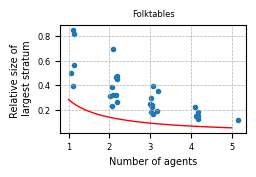

In [45]:
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.scatter(xs1, ys1)
plt.plot(reg_xs, reg_ys, color='red')
plt.xlabel('Number of agents')
plt.ylabel('Relative size of \n largest stratum')
plt.title('Folktables')

plot_name = 'ft_largest_stratum_ma.pdf'
# plt.savefig(f'/home/dhasade/audits/ml-audits/results/ECAI/plots/{plot_name}', bbox_inches='tight', dpi=300)